In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm

from utils import *

In [2]:
import sys
sys.path.append("../")

from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [4]:
# Define parameters
Nx = 10
Ny = 10
N = Nx * Ny
x_len = 50
y_len = 50

In [5]:
# Load ellipses
ells = np.loadtxt("./ellipses_data.txt").reshape((Nx,Ny,x_len,y_len))
ells.shape

(10, 10, 50, 50)

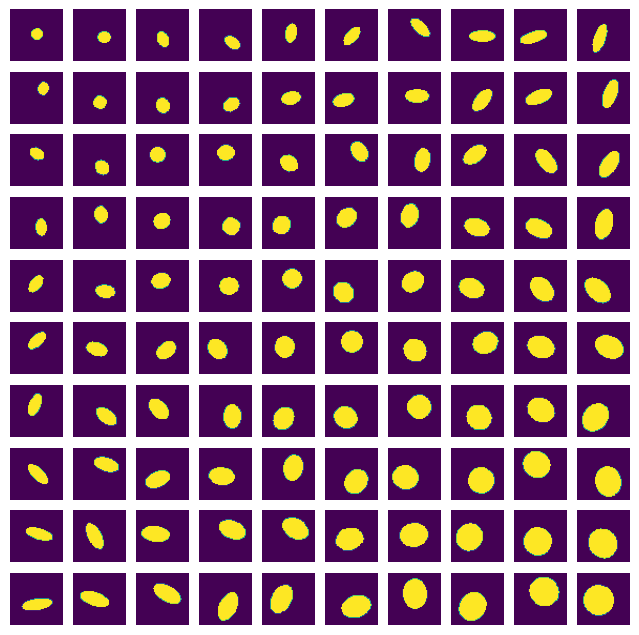

In [6]:
# Plot ellipses
fig, ax = plt.subplots(Nx, Ny, figsize=(8,8))
for i in range(Nx):
    for j in range(Ny):
        ax[i, j].imshow(ells[i, j])
        ax[i, j].set_axis_off()

In [17]:
# Create mm-spaces from imgs
ells_flat = ells.reshape(N,x_len,y_len)

posns = []
heights = []
Ms = []
LAMBDA_MAX = 0

for i in range(N):
    img = ells_flat[i]
    supp = np.dstack(np.where(img > 0))[0]
    height = img[supp[:,0],supp[:,1]]
    
    # height /= np.sum(height)
    M = np.sqrt(cost_matrix_d(supp, supp))

    posns.append(supp)
    heights.append(height)
    Ms.append(M)
    LAMBDA_MAX = max(LAMBDA_MAX, Ms[i].max() ** 2)

In [19]:
st = time.time()        
gw = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    height1 = heights[i] / np.sum(heights[i])
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j] / np.sum(heights[j])

        gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        gw[i, j] = GW_dist(M1, M2, gamma)
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")

np.save("results/gw_" + str(time.time()) + ".npy", gw)

/home/kothapa/miniconda3/envs/opt/lib/python3.11/site-packages/ot/lp/__init__.py:346: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [20]:
# Load gw matrix if needed
gw = np.load("results/gw_1719418179.9167495.npy")

/home/kothapa/miniconda3/envs/opt/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


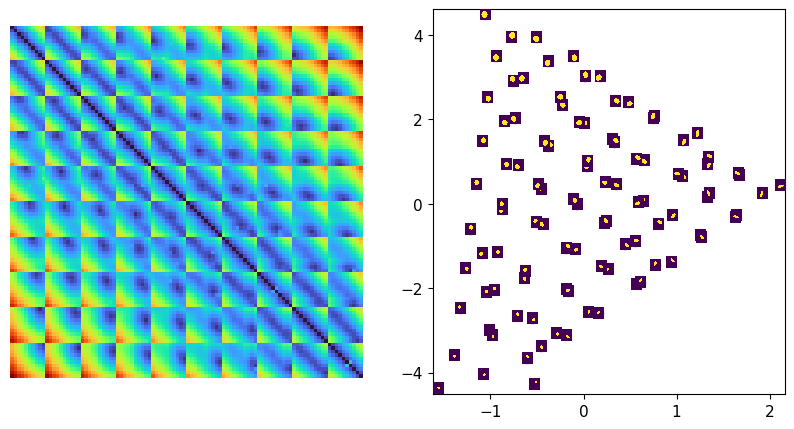

In [21]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gw,cmap = "turbo")
ax[0].axis("off")


mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(gw)
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

In [27]:
st = time.time()        
pgw = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    height1 = heights[i] / np.sum(heights[i])

    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j] / np.sum(heights[j])

        Lambda = LAMBDA_MAX
        gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)

        pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
        pgw[i, j]=pgw_trans+pgw_penalty 

pgw[pgw < 0] = 0
pgw = np.sqrt(pgw)
pgw += pgw.T

et = time.time()
print("PGW computation: " + str(np.round(et-st,2)) + "s")

np.save("results/pgw_" + str(time.time()) + ".npy", pgw)

/home/kothapa/Linearized_Partial_Gromov_Wasserstein/ellipses/../lib/opt.py:243: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


PGW computation: 3192.62s


In [25]:
# Load pgw matrix if needed
# pgw = np.load("results/pgw_1719418179.9167495.npy")

/home/kothapa/miniconda3/envs/opt/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


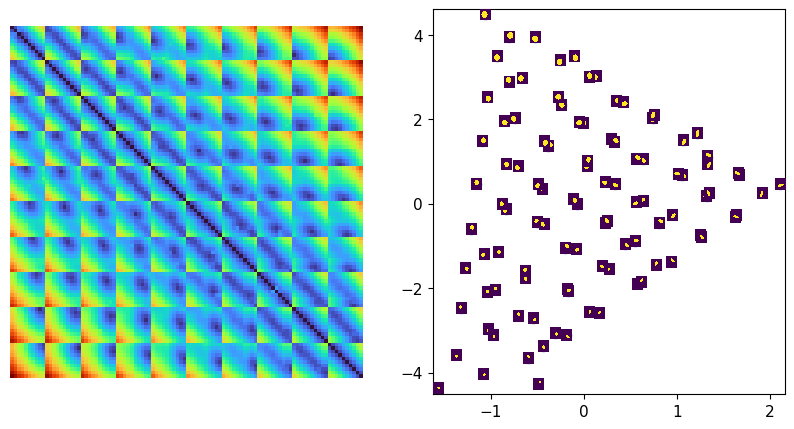

In [29]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pgw,cmap = "turbo")
ax[0].axis("off")


mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(pgw)
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

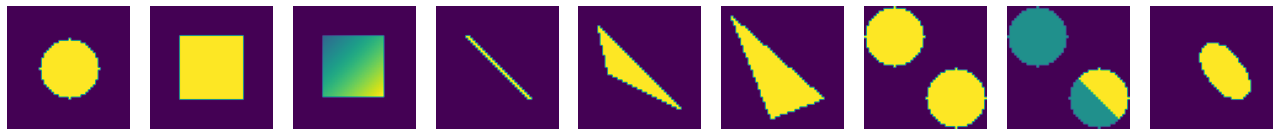

In [11]:
refs = []
imgs = []

fig,ax = plt.subplots(1,9,figsize=(18,2))
for x in ax.ravel():
    x.axis("off")

circ = cv2.circle(np.zeros((x_len,y_len)),(x_len//2,y_len//2),x_len//4,color=1,thickness=-1)
circ /= np.sum(circ)
ax[0].imshow(circ)
imgs.append(circ)
refs.append(mm_space_from_img(circ))

rec = cv2.rectangle(np.zeros((x_len,y_len)),(x_len//4,x_len//4),(3*x_len//4,3*x_len//4),color=1,thickness=-1)
rec /= np.sum(rec)
ax[1].imshow(rec)
imgs.append(rec)
refs.append(mm_space_from_img(rec))

rec2 = np.zeros((x_len,y_len))
for i in range(x_len//4,3*x_len//4):
    for j in range(x_len//4,3*x_len//4):
        rec2[i,j] = i+j
rec2 /= np.sum(rec2)
ax[2].imshow(rec2)
imgs.append(rec2)
refs.append(mm_space_from_img(rec2))

tmp_pts = [(x_len//4,y_len//4),(x_len//4 + 1,y_len//4),(3*x_len//4 + 1,3*y_len//4),(3*x_len//4,3*y_len//4)]
line = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
line /= np.sum(line)
ax[3].imshow(line)
imgs.append(line)
refs.append(mm_space_from_img(line))

tmp_pts = [(x_len//4 - 4,y_len//4 - 4),(x_len//4,y_len//2+2),(3*x_len//4+4,3*y_len//4+4)]
tri = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
tri /= np.sum(tri)
ax[4].imshow(tri)
imgs.append(tri)
refs.append(mm_space_from_img(tri))

tmp_pts = [(x_len//4 - 8,y_len//4 - 8),(x_len//4+8,y_len//2+20),(3*x_len//4+4,3*y_len//4)]
tri2 = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
tri2 /= np.sum(tri2)
ax[5].imshow(tri2)
imgs.append(tri2)
refs.append(mm_space_from_img(tri2))

circ2 = cv2.circle(np.zeros((x_len,y_len)),(x_len//4,y_len//4),x_len//4,color=1,thickness=-1) + cv2.circle(np.zeros((x_len,y_len)),(3*x_len//4,3*y_len//4),x_len//4,color=1,thickness=-1)
circ2 /= np.sum(circ2)
ax[6].imshow(circ2)
imgs.append(circ2)
refs.append(mm_space_from_img(circ2))

circ3 = np.copy(circ2)
for i in range(25,50):
    circ3[i,i:] *= 2
circ3 /= np.sum(circ3)
ax[7].imshow(circ3)
imgs.append(circ3)
refs.append(mm_space_from_img(circ3))

m_ell = ells_flat[28]
m_ell /= np.sum(m_ell)
ax[8].imshow(m_ell)
imgs.append(m_ell)
refs.append(mm_space_from_img(m_ell))

plt.tight_layout()
plt.show()

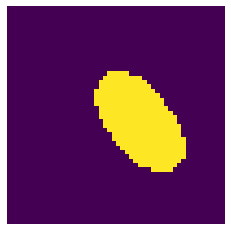

In [12]:
for i in range(9):
    plt.imshow(imgs[i])
    plt.axis("off")
    #plt.subplots_adjust(0,0,1,1,0,0)
    plt.savefig("./data/Figures/S_" + str(i+1),pad_inches=0,bbox_inches="tight")
    #plt.show()

In [13]:
#Compute LGW distances for all reference measures
Ps_per_ref = []
LGW_per_ref = []
times_per_ref = []
idx = 0
for k in range(len(refs)):
    supp,M,height = refs[k]
    Ps = []
    Ts = []
    st = time.time()
    for i in range(N):
        #Compute Wasserstein coupling
        M_ot = ot.dist(supp,posns[i])
        G0 = ot.emd(height,heights[i],M_ot/np.max(M_ot))
        
        #Compute GW coupling with initial coupling set to Wasserstein coupling G0
        constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")
        P = cg(height, heights[i], 0, 1, f, df, G0, armijo=False, C1=M, C2=Ms[i], constC=constC)
        Ps.append(P)
        
        #barycentric projection of GW coupling P
        T = (np.divide(P.T,height).T).dot(posns[i])
        Ts.append(T)

    #LGW
    lgw = np.zeros((N,N))
    for i in range(N):
        for j in range(i + 1, N):
            lgw[i, j] = LGW(Ts[i], Ts[j],height,metric="sq_loss")
    lgw += lgw.T
    et = time.time()
    print("Time for LGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")
    
    times_per_ref.append(et-st)
    Ps_per_ref.append(Ps)
    LGW_per_ref.append(lgw)

Time for LGW with ref space 0: 2.94 min
Time for LGW with ref space 1: 16.57 min
Time for LGW with ref space 2: 12.19 min
Time for LGW with ref space 3: 0.14 min
Time for LGW with ref space 4: 1.61 min
Time for LGW with ref space 5: 5.48 min
Time for LGW with ref space 6: 7.94 min
Time for LGW with ref space 7: 8.37 min
Time for LGW with ref space 8: 2.14 min


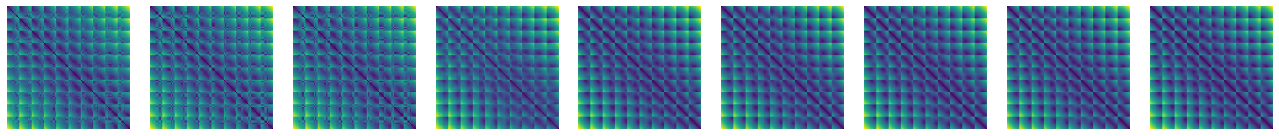

In [14]:
fig, ax = plt.subplots(1,9,figsize=(18,2))
for i in range(9):
    ax[i].imshow(LGW_per_ref[i])
    ax[i].axis("off")
plt.tight_layout()
plt.show()

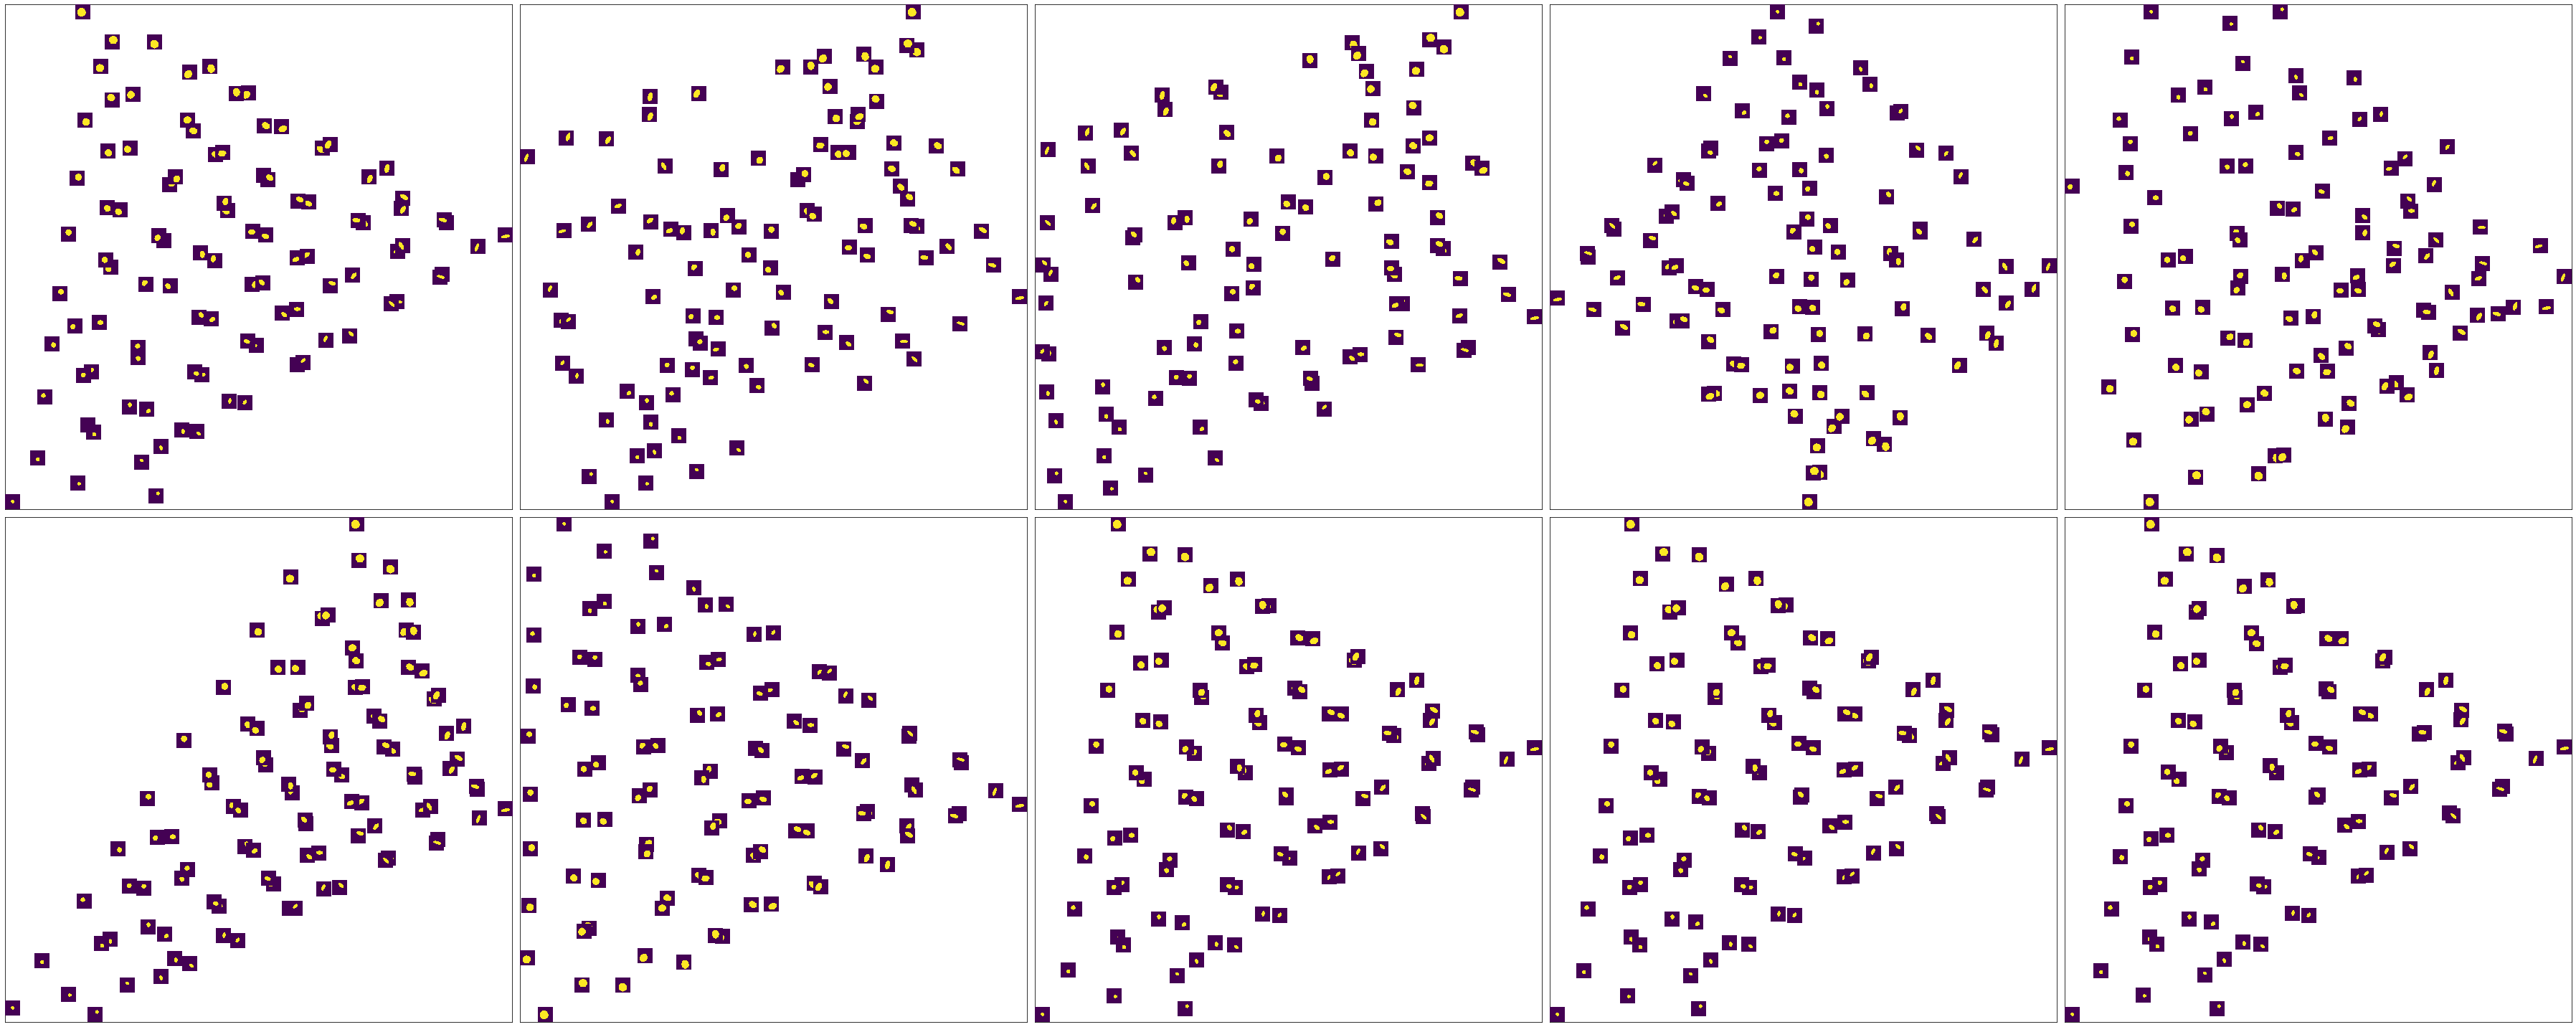

In [15]:
#plot ref spaces, associated LGW distances and MDS embeddings
fig, ax = plt.subplots(2,5, figsize = (50,20))

for i in range(5):
    ax[0,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax[1,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    
    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    if i == 0:
        embedding1 = mds.fit_transform(gw)
    else:
        embedding1 = mds.fit_transform(LGW_per_ref[i-1])
    #plot
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
    del mds
    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    embedding2 = mds.fit_transform(LGW_per_ref[i+4])
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
plt.tight_layout()
plt.savefig("./data/Figures/embeddings")
plt.show()

In [29]:
import utils

In [36]:
reload(utils)

<module 'utils' from '/Users/florian/code/LGW/utils.py'>

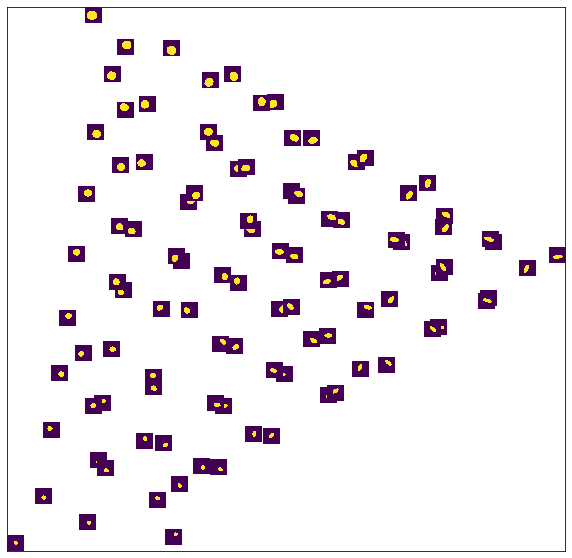

In [40]:
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


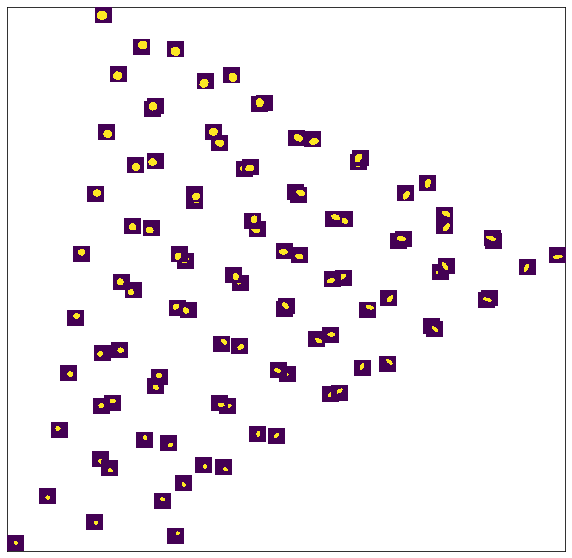

In [37]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


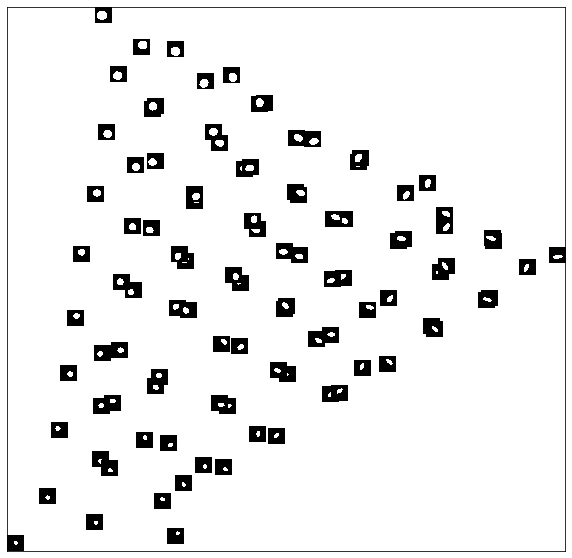

In [28]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


In [22]:
print("        MRE       PCC      time in mins     no. of points")
for i in range(9):
    m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
    m_lgw = np.ma.masked_equal(LGW_per_ref[i], 0.0, copy=False)
    print("Ref " + str(i+1) + ":  " 
          + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)) 
          + "    " 
          + str(np.round(np.corrcoef(gw.flatten(),m_lgw.flatten())[1,0],4))
          + "    "
          + str(np.round((times_per_ref[i])/60,2))
          + "             "
          + str(np.sum(imgs[i] != 0)))

        MRE       PCC      time in mins     no. of points
Ref 1:  0.3357    0.8906    2.78             441
Ref 2:  0.3247    0.8756    15.92             676
Ref 3:  0.3178    0.8865    11.77             625
Ref 4:  0.1576    0.9863    0.13             52
Ref 5:  0.0376    0.9987    1.54             289
Ref 6:  0.03    0.9991    5.45             545
Ref 7:  0.0167    0.9993    7.68             882
Ref 8:  0.016    0.9993    8.28             882
Ref 9:  0.019    0.9993    2.06             317


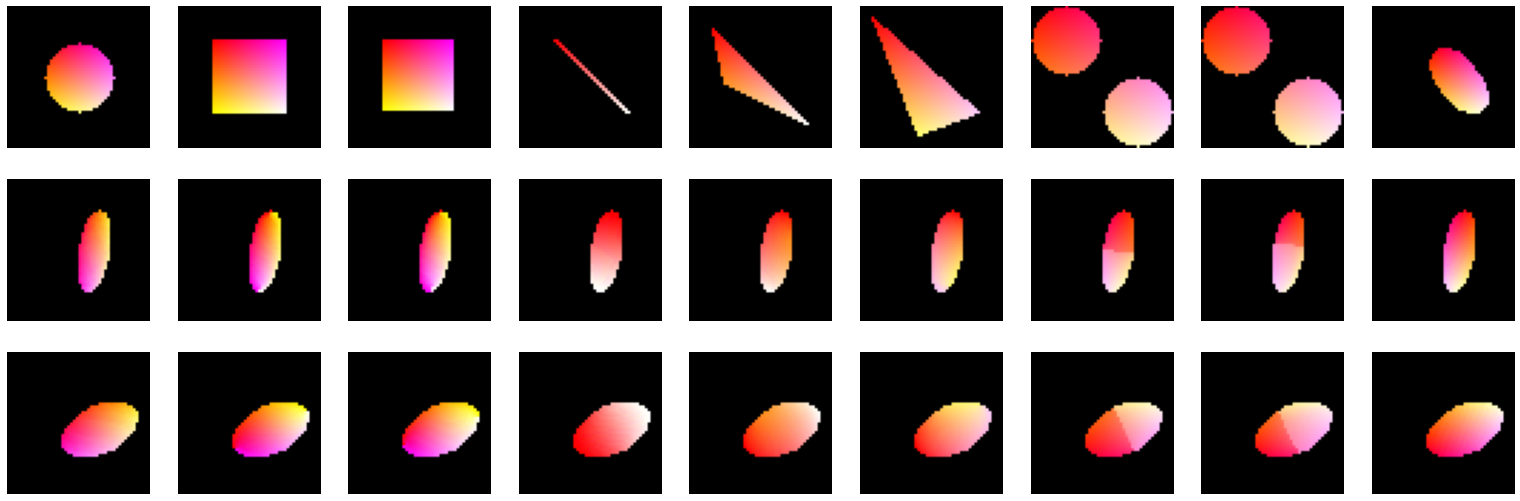

In [23]:
fig, ax = plt.subplots(3,9,figsize=(27,9))
nos = [90,93]
for i in range(9):
    img1,img2 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[0]],ot.unif(len(posns[nos[0]])),Ps_per_ref[i][nos[0]],return_img=True,plot_img=False,sub_box=True)   
    ax[0,i].imshow(img1)
    ax[0,i].axis("off")
    
    ax[1,i].imshow(img2)
    ax[1,i].axis("off")
    
    img3 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[1]],ot.unif(len(posns[nos[1]])),Ps_per_ref[i][nos[1]],return_img=True,plot_img=False,sub_box=True)[1]   
    ax[2,i].imshow(img3)
    ax[2,i].axis("off")